In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import re
from collections import Counter
import logging
from time import time

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

import spacy
import en_core_web_sm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import ward, dendrogram, linkage

from spellchecker import SpellChecker

plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)


C:\Users\rujjn\Anaconda3\envs\capstone2\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
training_set  = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
training_set.head()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computers have on people are great learning skills/affects...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and...",5,4,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that this...",4,3,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that many experts say that computers do not benifit ou...",5,5,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a positive effect on people. The computers connect ...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
essay_id          12976 non-null int64
topic             12976 non-null int64
essay             12976 non-null object
rater1_domain1    12976 non-null int64
rater2_domain1    12976 non-null int64
rater3_domain1    128 non-null float64
target_score      12976 non-null int64
rater1_domain2    1800 non-null float64
rater2_domain2    1800 non-null float64
topic2_target     1800 non-null float64
rater1_trait1     2292 non-null float64
rater1_trait2     2292 non-null float64
rater1_trait3     2292 non-null float64
rater1_trait4     2292 non-null float64
rater1_trait5     723 non-null float64
rater1_trait6     723 non-null float64
rater2_trait1     2292 non-null float64
rater2_trait2     2292 non-null float64
rater2_trait3     2292 non-null float64
rater2_trait4     2292 non-null float64
rater2_trait5     723 non-null float64
rater2_trait6     723 non-null float64
rater3_trait1     128

<IPython.core.display.Javascript object>


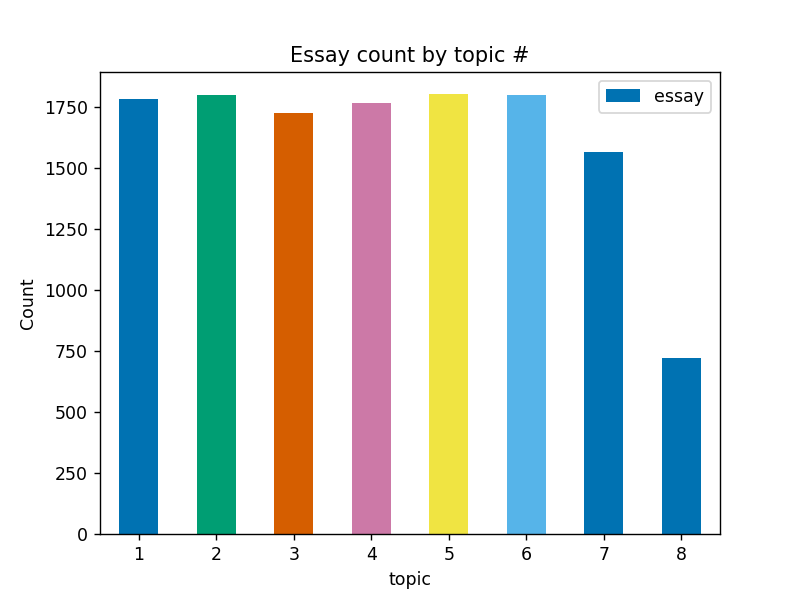

Text(0,0.5,'Count')

In [4]:
training_set.groupby('topic').agg('count').plot.bar(y='essay', rot=0)
plt.title('Essay count by topic #')
plt.ylabel('Count')


In [5]:
# Count characters and words for each essay
training_set['char_len'] = training_set['essay'].str.len()
training_set['word_count'] = training_set['essay'].str.strip().str.split('[\W_]+').str.len()

<IPython.core.display.Javascript object>


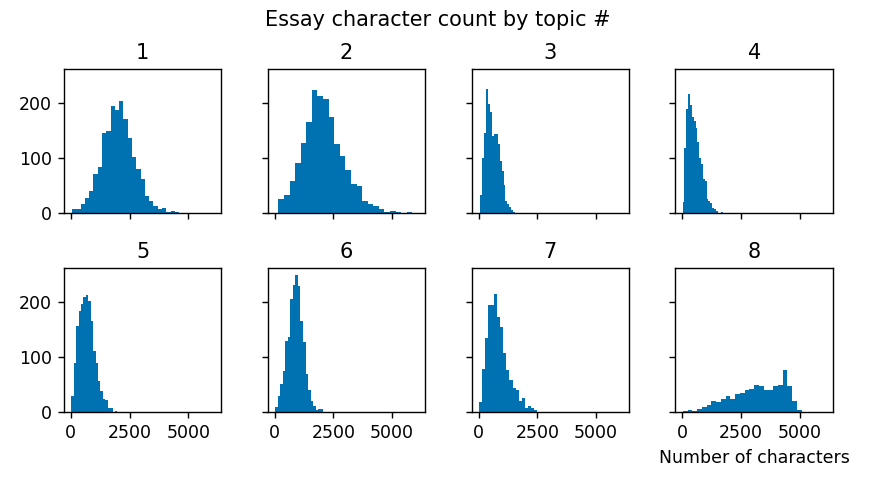

In [6]:
training_set.hist(column='char_len', by='topic', bins=25, sharey=True, sharex=True, layout=(2, 4), figsize=(7,4), rot=0) 
plt.suptitle('Essay character count by topic #')
plt.xlabel('Number of characters')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<IPython.core.display.Javascript object>


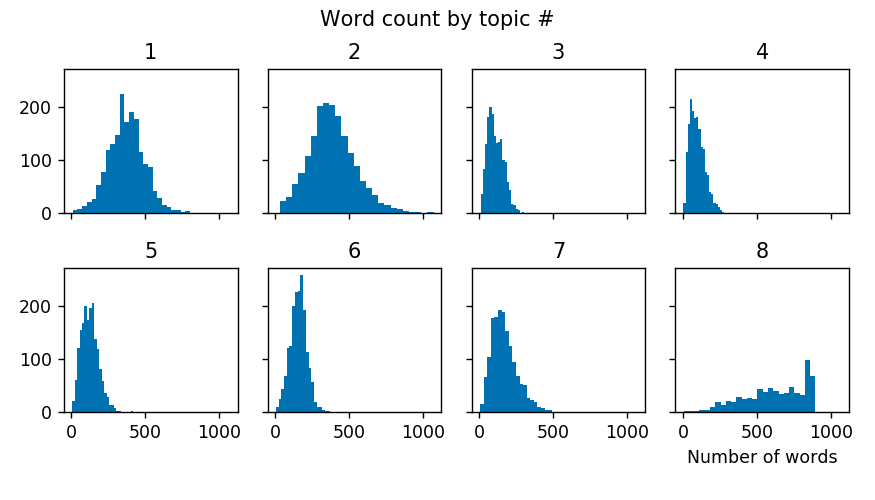

In [7]:
training_set.hist(column='word_count', by='topic', bins=25, sharey=True, sharex=True, layout=(2, 4), figsize=(7,4), rot=0) 
plt.suptitle('Word count by topic #')
plt.xlabel('Number of words')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:
training_set.groupby(['topic'])['target_score'].agg(['min','max','count','nunique'])

,min,max,count,nunique
topic,,,,
1,2,12,1783,11
2,1,6,1800,6
3,0,3,1726,4
4,0,3,1770,4
5,0,4,1805,5
6,0,4,1800,5
7,2,24,1569,23
8,10,60,723,34


<IPython.core.display.Javascript object>


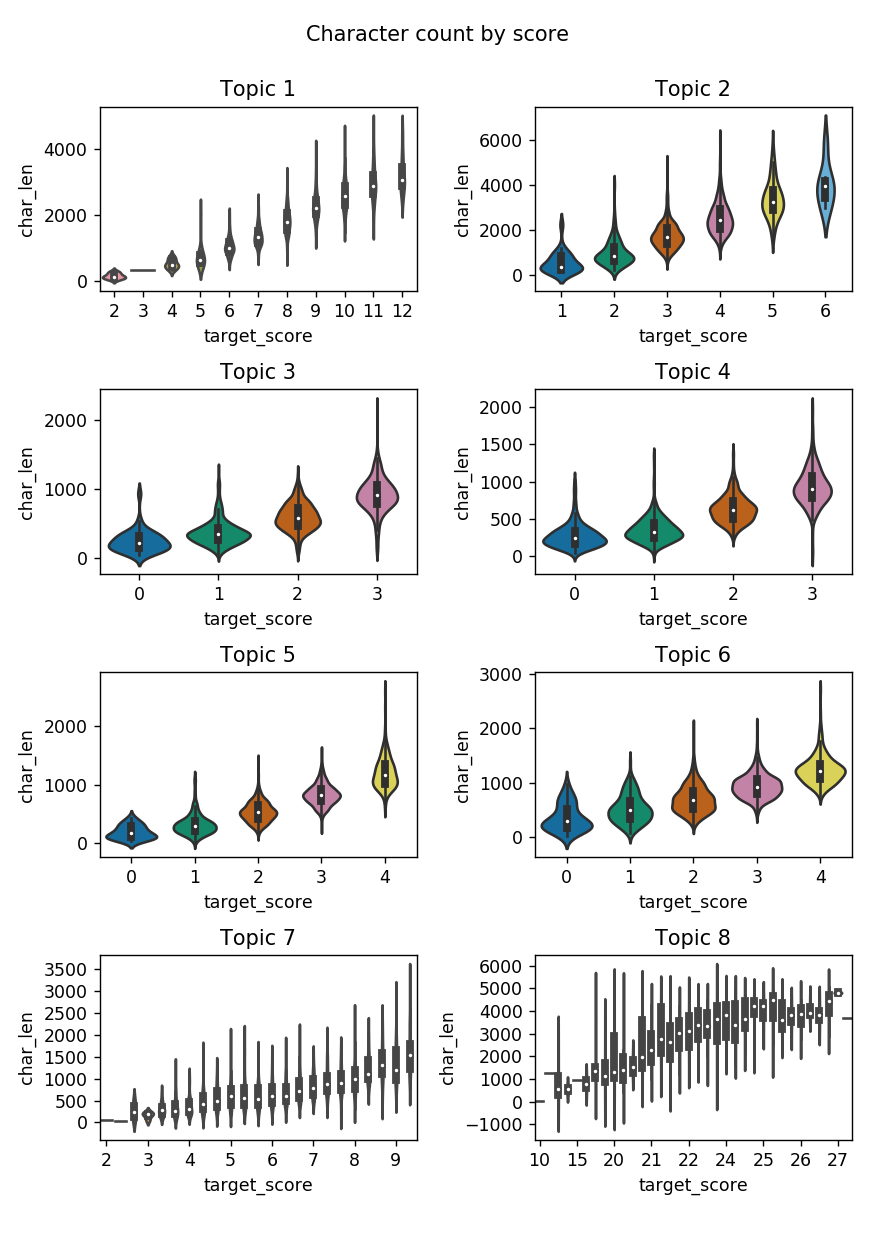

In [9]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(7,10))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.violinplot(x='target_score', y='char_len', data=training_set[training_set['topic'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Character count by score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<IPython.core.display.Javascript object>


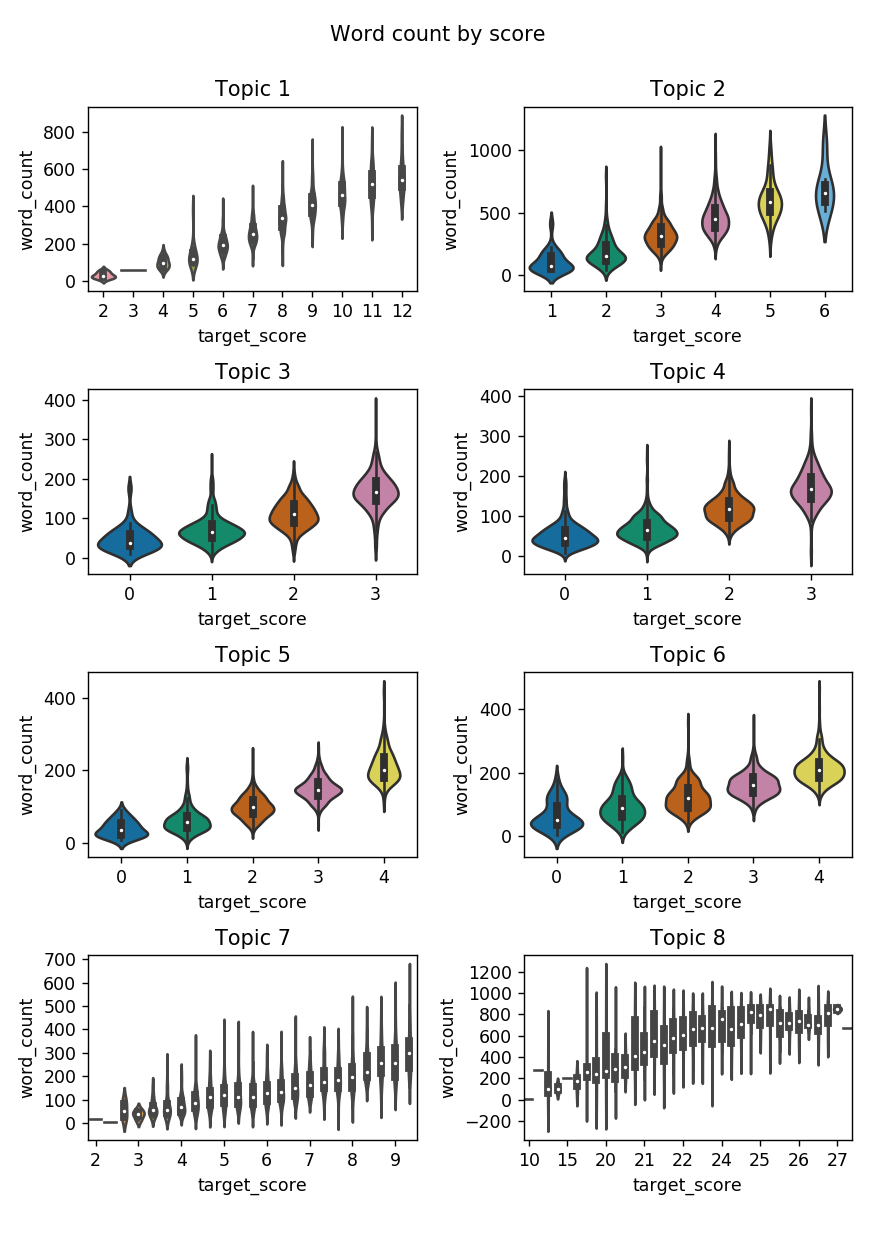

In [10]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(7,10))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.violinplot(x='target_score', y='word_count', data=training_set[training_set['topic'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Word count by score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<IPython.core.display.Javascript object>


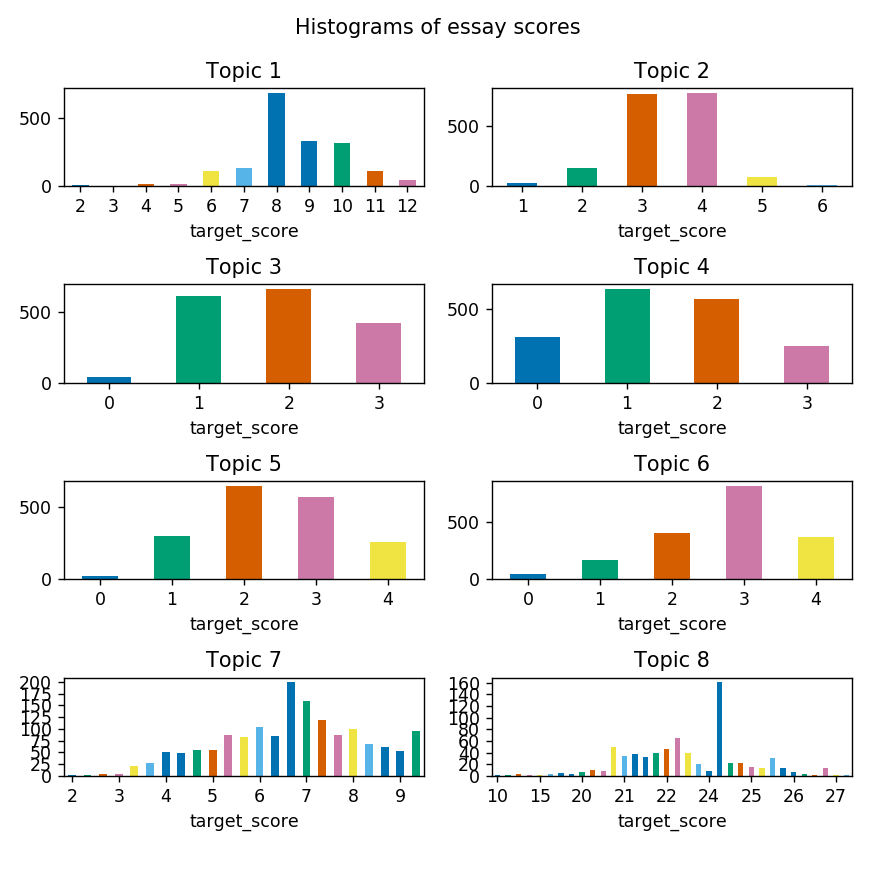

In [11]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(7,7), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        training_set[training_set['topic'] == topic_number]\
            .groupby('target_score')['essay_id']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of essay scores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [64]:
# subset for faster runtimes

t12 = training_set[training_set['topic'] < 3]

In [65]:
# Runtime approximately 1-2 hours

# # Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en_core_web_sm')

tokens = []
# lemma = []
# pos = []

stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}']) # remove it if you need punctuation 


for essay in nlp.pipe(t12['essay'].astype('unicode').values, batch_size=100,
                        n_threads=3):
    if essay.is_parsed:
        tokens.append([n.text for n in essay if n not in stop_words])
#         lemma.append([n.lemma_ for n in essay])
#         pos.append([n.pos_ for n in essay])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
#         lemma.append(None)
#         pos.append(None)

t12['tokens'] = tokens
# training_set['lemma'] = lemma
# training_set['pos'] = pos

t12.to_pickle('t12.pkl')

C:\Users\rujjn\Anaconda3\envs\capstone2\lib\site-packages\ipykernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [67]:
nlp.pipe_names

['tagger', 'parser', 'ner']

In [12]:
training_set = pd.read_pickle('training_set.pkl')
training_set.iloc[0]

essay_id                                                                                                            1
topic                                                                                                               1
essay             Dear local newspaper, I think effects computers have on people are great learning skills/affects...
rater1_domain1                                                                                                      4
rater2_domain1                                                                                                      4
rater3_domain1                                                                                                    NaN
target_score                                                                                                        8
rater1_domain2                                                                                                    NaN
rater2_domain2                                          

In [ ]:
# load nltk's SnowballStemmer as variabled 'stemmer'
import re
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems
tokenize_and_stem(training_set.iloc[0]['essay'])

In [ ]:
essays_topic2 = []

for score in range(1, 7):
    essays_topic2.append(training_set[(training_set['topic'] == 2) \
                               & (training_set['target_score'] == score)]\
                              ['tokens']\
                              .astype('unicode')\
                              .sum()[:400000]) # limitation of TfidfVectorizer

In [ ]:
def tokenize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


In [19]:
t12_df = training_set[training_set.topic < 2]
t12_df.shape

(1783, 33)

In [61]:
# def preprocess_data2feature(X,target_col):
#     # Generate feature columns for 15 custom features and a target value column    
#     feature_columns = ["essay","word_count","long_word_count","avg_word_length_per_essay","wrong_words","no_of_domain_words","word_to_sent_ratio","num_of_characters","sentence_count","noun_count","verb_count","comma_count","punctuation_count","adjective_count","adverb_count","quotation_mark_count","spelling_mistakes","target"]
#     feature_pd = pd.DataFrame(index = X.index, columns = feature_columns)
#     feature_pd['essay'] = X['essay']
#     feature_pd['target'] = X[target_col]
    
#     return feature_pd

def generateFeatures(df, target_col): 

    start = time()
    
    # Generate feature columns for 15 custom features and a target value column    
    feature_columns = ["essay","split","word_count","long_word_count","avg_word_length_per_essay","wrong_words","no_of_domain_words","word_to_sent_ratio","num_of_characters","sentence_count","noun_count","verb_count","comma_count","punctuation_count","adjective_count","adverb_count","quotation_mark_count","spelling_mistakes","target"]
    feature_df = pd.DataFrame(index = df.index, columns = feature_columns)
    feature_df['essay'] = df['essay']
    feature_df['target'] = df[target_col]

    
    # Extract features from the given essay and assign the value/count to the respective column.
#     for index,row in feature_df.iterrows():
        
    feature_df['split'] = df['essay'].apply(lambda x: x.split() if x[0]!='@' else x)
#     punctuation = ['.','?', '!', ':', ';']
#     #Comma count
#     comma_count = text.count(',')
#     df['comma_count'] = comma_count

#     #Punctuation count
#     punctuation_count = 0
#     for punct in punctuation:
#         punctuation_count += text.count(punct)
#     row['punctuation_count'] = punctuation_count

#     #Quotation marks count
#     quotation_mark_count = text.count('"')
#     quotation_mark_count += text.count("'")
#     row['quotation_mark_count'] = quotation_mark_count

#     #Add the sentence count

#     tokenized_essay = nltk.sent_tokenize(text)
#     sent_count = len(tokenized_essay)
#     row['sentence_count'] = sent_count

#     #Add word count after removing the stop words.
#     words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}']) # remove it if you need punctuation 
    feature_df['split'].apply(lambda w: [word for word in w if word not in stop_words])

#     row['word_count'] = word_count

#     #Long word count
#     long_word_count = 0
#     total_word_length = 0
#     for word in words:
#         total_word_length += len(word)
#         if len(word) > 6:
#             long_word_count +=1
#     row['long_word_count'] = long_word_count

#     #Average word length per essay
#     row['avg_word_length_per_essay'] = round((total_word_length/float(len(words))),2)


# #         tool = grammar_check.LanguageTool('en-US')
# #         matches = tool.check(text)
# #         row['spelling_mistakes'] = len(matches)

#     #POS TAGS
#     count= Counter([j for i,j in nltk.pos_tag(words)])

#     row['noun_count'] = count['NN'] + count['NNS'] + count['NNPS'] + count['NNP']
#     row['verb_count'] = count['VB'] + count['VBG'] + count['VBP'] + count['VBN'] + count['VBZ']
#     row['adjective_count'] = count['JJ'] + count['JJR'] 
#     row['adverb_count'] = count['RB'] + count['RBR'] + count['RBS']

#     #No_of_domain_words and wrong words after removing the stop words and punctuations from the essay.
# #         cnt = 0
#     wrong_word_count = 0
# #         for word in words:
# #             if wn.synsets(word):
# #                 cnt += 1
# #             else:
# #                 wrong_word_count += 1
# #         row['no_of_domain_words'] = cnt
#     row['wrong_words'] = wrong_word_count        

#     #Word to sentence ratio
#     row['word_to_sent_ratio'] = round(float(word_count/float(sent_count)),2)

#     #Number of characters
#     row['num_of_characters'] = nltk.FreqDist(text).N()

    #Debugging
#     if index%500==0:
#         print("made features for rows with index up to ",index)

    end = time()
    print("Generated the features for the entire data-set in {:.4f} minutes".format((end - start)/60.0))
        
    return feature_df
       
# def GenerateFeatures(X):
#     start = time()
#     featureSet2(X)
#     end = time()
#     print("Generated the features for the entire data-set in {:.4f} minutes".format((end - start)/60.0))


In [62]:
e_df = generateFeatures(t12_df, 'target_score')

Generated the features for the entire data-set in 0.0023 minutes


In [63]:
e_df.head()

,essay,split,word_count,long_word_count,avg_word_length_per_essay,wrong_words,no_of_domain_words,word_to_sent_ratio,num_of_characters,sentence_count,noun_count,verb_count,comma_count,punctuation_count,adjective_count,adverb_count,quotation_mark_count,spelling_mistakes,target
0,"Dear local newspaper, I think effects computers have on people are great learning skills/affects...","[Dear, local, newspaper,, I, think, effects, computers, have, on, people, are, great, learning, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
1,"Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking and...","[Dear, @CAPS1, @CAPS2,, I, believe, that, using, computers, will, benefit, us, in, many, ways, l...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
2,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that this...","[Dear,, @CAPS1, @CAPS2, @CAPS3, More, and, more, people, use, computers,, but, not, everyone, ag...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
3,"Dear Local Newspaper, @CAPS1 I have found that many experts say that computers do not benifit ou...","[Dear, Local, Newspaper,, @CAPS1, I, have, found, that, many, experts, say, that, computers, do,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
4,"Dear @LOCATION1, I know having computers has a positive effect on people. The computers connect ...","[Dear, @LOCATION1,, I, know, having, computers, has, a, positive, effect, on, people., The, comp...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


In [ ]:
nltk.download('averaged_perceptron_tagger')

In [ ]:
spell = SpellChecker()
spell.word_frequency.load_words(['websites', 'myspace', 'facebook', 'guaranteed', 'conveniences', 'convenient', 'website'])

In [ ]:
# find those words that may be misspelled
misspelled = spell.unknown(essay_list[1])

for word in misspelled:
    # Get the one `most likely` answer
    print(word, '-->', spell.correction(word))

    # Get a list of `likely` options
#     print(spell.candidates(word))

In [ ]:
# t2 = training_set[training_set.topic == 2]['essay']
essays = training_set[training_set.topic < 4]['essay']
essay_list = []

for i, essay in enumerate(essays):
    # do some pre-processing and return list of words for each essay
    essay_list.append(simple_preprocess(essay))
print(i, 'essays preprocessed.')

In [ ]:
# train model with essay
model = Word2Vec(training_set.tokens, min_count=1)

# get vector data
X = model.wv
Xv = model.wv.vectors
del model
print(len(Xv))

In [ ]:
X.vocab

In [ ]:
X.similarity('magazine', 'book')

In [ ]:
X.similarity('newspaper', 'computer')

In [ ]:
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(Xv, assign_clusters=True)
print (assigned_clusters)
 
words = list(X.vocab)
for i, word in enumerate(words):  
    print (word + ":" + str(assigned_clusters[i]))
 
 
 
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(Xv)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(Xv))
 
silhouette_score = metrics.silhouette_score(Xv, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
# np.set_printoptions(suppress=True)
Y = tsne.fit_transform(X.vectors[0:80,:])

plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(X.index2word, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()


In [ ]:
l = linkage(X.vectors, method='complete', metric='seuclidean')

In [ ]:
# calculate full dendrogram
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    truncate_mode='level', 
    p=2,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    orientation='left',
    leaf_label_func=lambda v: str(X.index2word[v])
)
plt.show()

In [ ]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(essays) #fit the vectorizer to essays

print(tfidf_matrix.shape)

In [ ]:
tfidf_matrix

In [ ]:
dist = 1 - cosine_similarity(tfidf_matrix)

In [ ]:
kmeans = KMeans(n_clusters=6, init='random')

kmeans.fit(tfidf_matrix)

clusters = kmeans.labels_.tolist()

In [ ]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
labels = [0, 1, 2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(6, 6))
ax = dendrogram(linkage_matrix, truncate_mode='level', p=0, show_contracted=False, orientation="right", labels=clusters);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.tight_layout() #show plot with tight layout
plt.show()

In [ ]:
# principal component analysis

pca = PCA(n_components=2)

components = pca.fit_transform(dist)

fig, ax = plt.subplots(figsize=(5,5))

g = ax.scatter(components[:,0], components[:,1], label=labels, c=labels, s=100, cmap=plt.cm.get_cmap('tab10', 6))
ax.set_title('Principal Component Analysis')
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')

# label points
for i, txt in enumerate(labels):
    ax.annotate(txt, (components[i,0],components[i,1]), xytext=(5, 5), textcoords='offset points',)

# This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: labels[val])
plt.colorbar(g, ax=ax, ticks=[0, 1, 2, 3, 4, 5], format=formatter);

# # Set the clim so that labels are centered on each block
g.set_clim(vmin=-0.5, vmax=5.5)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
essaybag = training_set[training_set['topic'] == 2]['lemma'].astype('unicode').tolist()
labels = training_set[training_set['topic'] == 2]['target_score'].tolist()

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(essaybag) #fit the vectorizer to essays

print(tfidf_matrix.shape)

dist = 1 - cosine_similarity(tfidf_matrix)

# principal component analysis

pca = PCA(n_components=2)

components = pca.fit_transform(dist)



In [ ]:
label_set = np.array(list(set(labels)))

fig, ax = plt.subplots(figsize=(8,8))

g = ax.scatter(components[:,0], components[:,1], label=labels, c=labels, s=5, cmap=plt.cm.get_cmap('tab10', 6))
ax.set_title('Principal Component Analysis')
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')

# # label points
# for i, txt in enumerate(labels):
#     ax.annotate(txt, (components[i,0],components[i,1]), xytext=(5, 5), textcoords='offset points',)

# # This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: label_set[val])
plt.colorbar(g, ax=ax, ticks=[0, 1, 2, 3, 4, 5], format=formatter);

# # # Set the clim so that labels are centered on each block
g.set_clim(vmin=-0.5, vmax=5.5)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en_core_web_sm')

# Determine semantic similarities
doc1 = nlp(essay1)
doc2 = nlp(essay2)
similarity = doc1.similarity(doc2)
print('')
print('similarity:')
print(similarity)

In [ ]:
training_set[(training_set['essay'].str.len() > 1000)\
             & (training_set['essay'].str.len() < 5050)\
             & (training_set['topic'] == 2)\
             & (training_set['target_score'] == 6)]\
            ['essay']

In [ ]:
sample1 = training_set.loc[2115, 'essay'] 
sample2 = training_set.loc[2913, 'essay'] 

In [ ]:
# Tokenize essay
tokens = word_tokenize(sample1)

# Convert the tokens into lowercase: lower_tokens
lower_tokens = [t.lower() for t in tokens]

# Retain alphabetic words: alpha_only
alpha_only = [t for t in lower_tokens if t.isalpha()]

# Remove all stop words: no_stops
stop_words = set(stopwords.words('english'))
no_stops = [t for t in alpha_only if t not in stop_words]

# Instantiate the WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
# Lemmatize all tokens into a new list: lemmatized
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
# Create the bag-of-words: bow
bow = Counter(lemmatized)
# Print the 10 most common tokens
print(bow.most_common(10))

In [ ]:
import nltk
nltk.download('wordnet')

In [ ]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en_core_web_sm')

# Process whole documents
text = (sample1)
doc = nlp(sample1)
print(doc)

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

# Determine semantic similarities
doc1 = nlp(sample1)
doc2 = nlp(sample2)
similarity = doc1.similarity(doc2)
print('')
print('similarity:')
print(similarity)

In [ ]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(u'San Francisco considers banning sidewalk delivery robots')
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)
    
from spacy.tokens import Span
doc = nlp(u'FB is hiring a new VP of global policy')
doc.ents = [Span(doc, 0, 1, label=doc.vocab.strings[u'ORG'])]
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [ ]:
from keras.models import Sequential